### Plot main results:  
    - heatmap of information as function of model parameters (horiz/ama weight vs center/surround weight)  
    - where ganglion cells map onto this heatmap
    - cumulative information of full model, horizontal, amacrine only models, ganglion cell, ideal filter, center vs frequency
    - total information vs SNR

In [1]:
import numpy as np
import collections
from functools import partial

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import difference_of_gaussians

from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Signal

In [12]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/data/images/Tkacik/cd01A'
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 70 files in directory.


In [13]:
patches[0].shape

(1006, 1006)

In [14]:
patch_space = np.linspace(0, spacing*patches[0].shape[0], patches[0].shape[0])

In [16]:
patch_space[-1]

21.869565217391305

In [30]:
? np.fft.rfft2

In [46]:
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches01A, spacing=spacing)

In [22]:
p = patches[0]

In [24]:
p_fft = np.fft.rfft2(p, s=np.array(p.shape) + np.array(p.shape) - 1)

In [33]:
p.shape

(1006, 1006)

In [41]:
p_fft = np.fft.rfft2(p)

In [32]:
np.array(p.shape) + np.array(p.shape) - 1

array([2011, 2011])

In [42]:
p_fft.shape

(1006, 504)

In [43]:
np.fft.fft2(p).shape

(1006, 1006)

In [44]:
blah = np.fft.fftshift(abs(np.fft.fft2(p)))

In [48]:
np.fft.rfft2(p).shape

(1006, 504)

In [53]:
np.fft.fft2(p, s=2*np.array(p.shape)-1).shape

(2011, 2011)

In [58]:
padded_abs_fft = np.fft.fftshift(abs(np.fft.fft2(p, s=2*np.array(p.shape)-1)))
padded_1d = rotavg(padded_abs_fft)

In [59]:
abs_fft = np.fft.fftshift(abs(np.fft.fft2(p)))
abs_1d = rotavg(abs_fft)

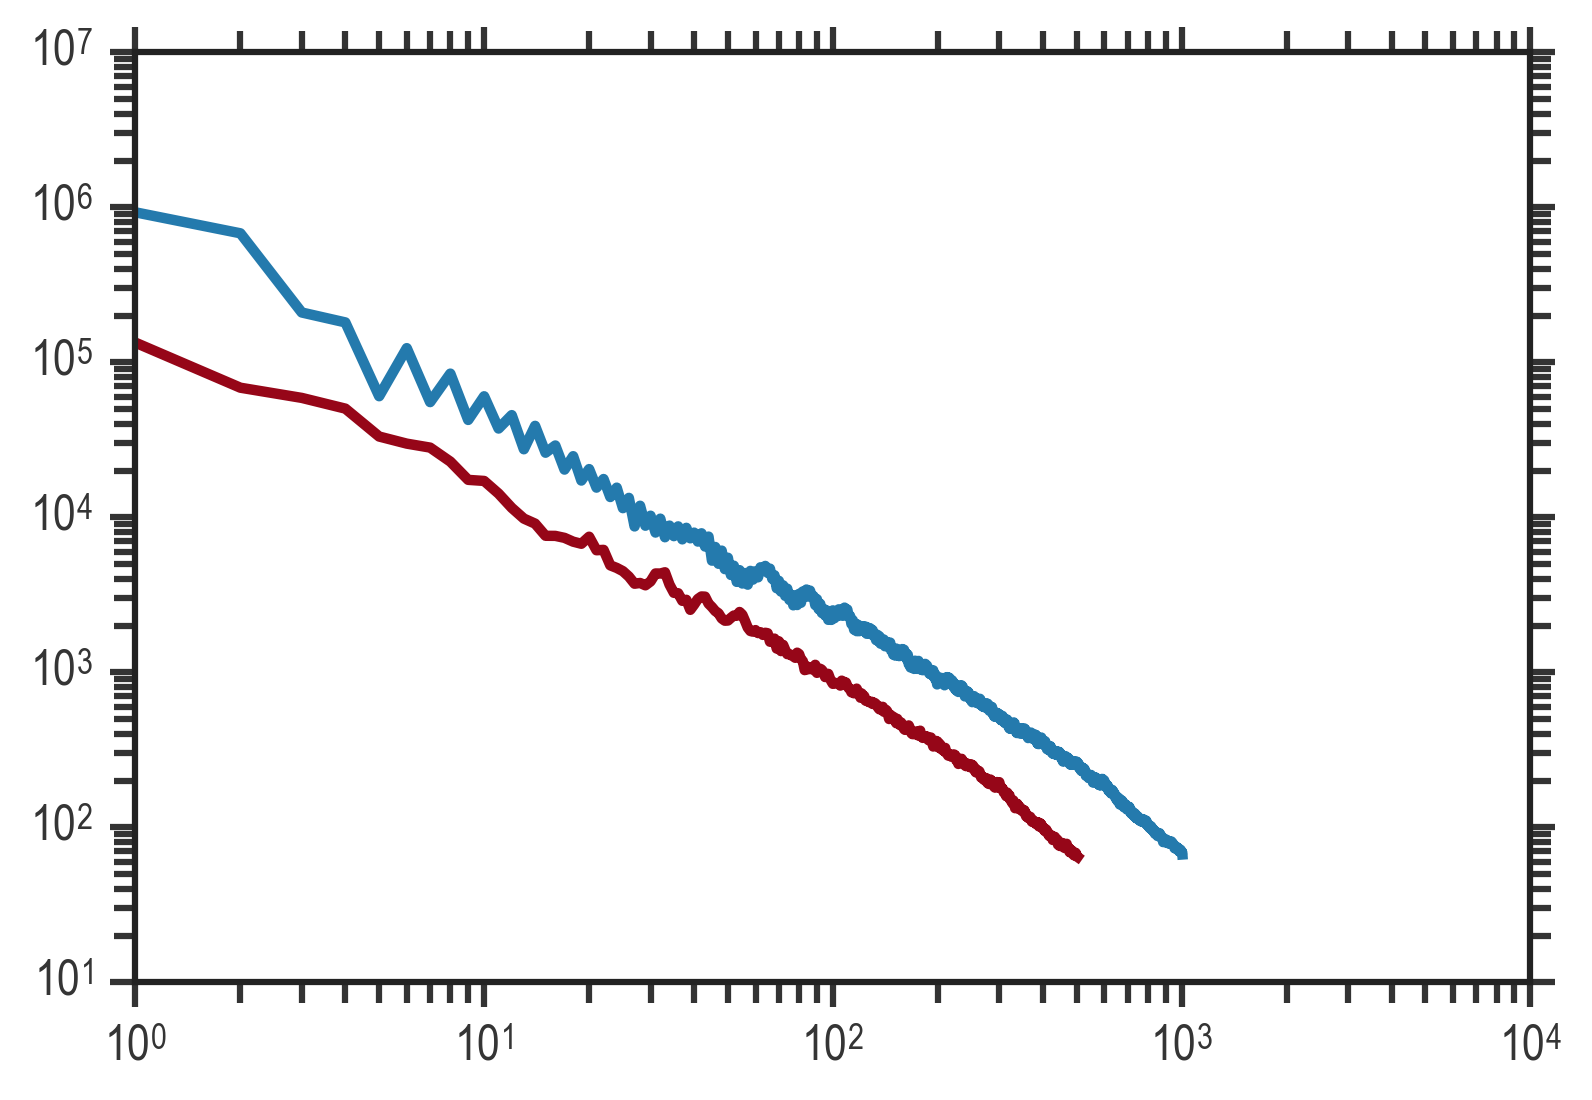

In [61]:
plt.plot(padded_1d)
plt.plot(abs_1d)
plt.xscale('log')
plt.yscale('log')

In [63]:
freqs_padded = np.fft.fftfreq(2*len(padded_1d), spacing)[:len(padded_1d)]
freqs_abs = np.fft.fftfreq(2*len(abs_1d), spacing)[:len(abs_1d)]

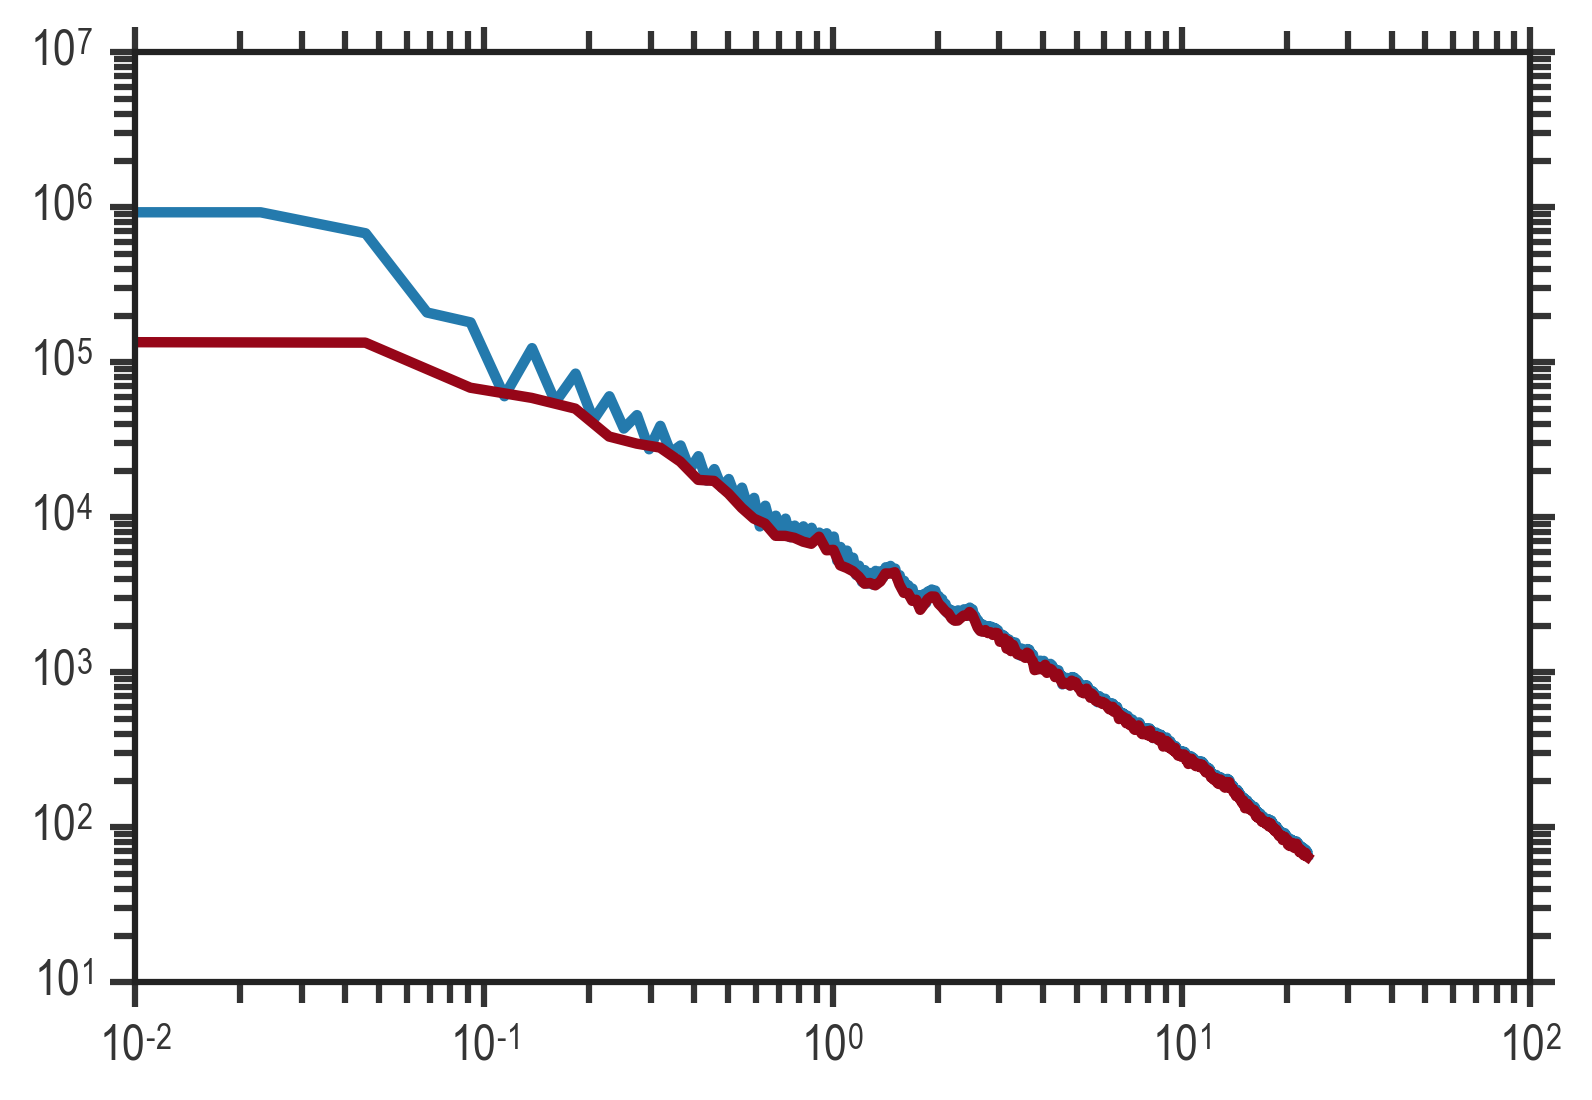

In [69]:
plt.plot(freqs_padded, padded_1d)
plt.plot(freqs_abs, abs_1d)
plt.xscale('log')
plt.yscale('log')

In [70]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt_padded, pcov = curve_fit(func, freqs_padded[1:], padded_1d[1:])
popt_abs, pcov = curve_fit(func, freqs_abs[1:], abs_1d[1:])

In [71]:
popt_padded

array([  1.06493694e+04,   1.20079806e+00])

In [72]:
popt_abs

array([  7.09171077e+03,   9.65086578e-01])

In [75]:
popt_padded[1]

1.200798060076913

In [74]:
popt_abs[1]

0.9650865775630838

In [76]:
all_ffts_2d = [np.fft.fftshift(abs(np.fft.fft2(p))) for p in patches]
all_ffts_1d = [rotavg(fft_2d) for fft_2d in all_ffts_2d]

In [77]:
np.stack(all_ffts_1d).shape

(70, 504)

In [78]:
from scipy.stats import sem

In [79]:
errors = sem(np.stack(all_ffts_1d), axis=0)

In [82]:
errors.shape

(504,)

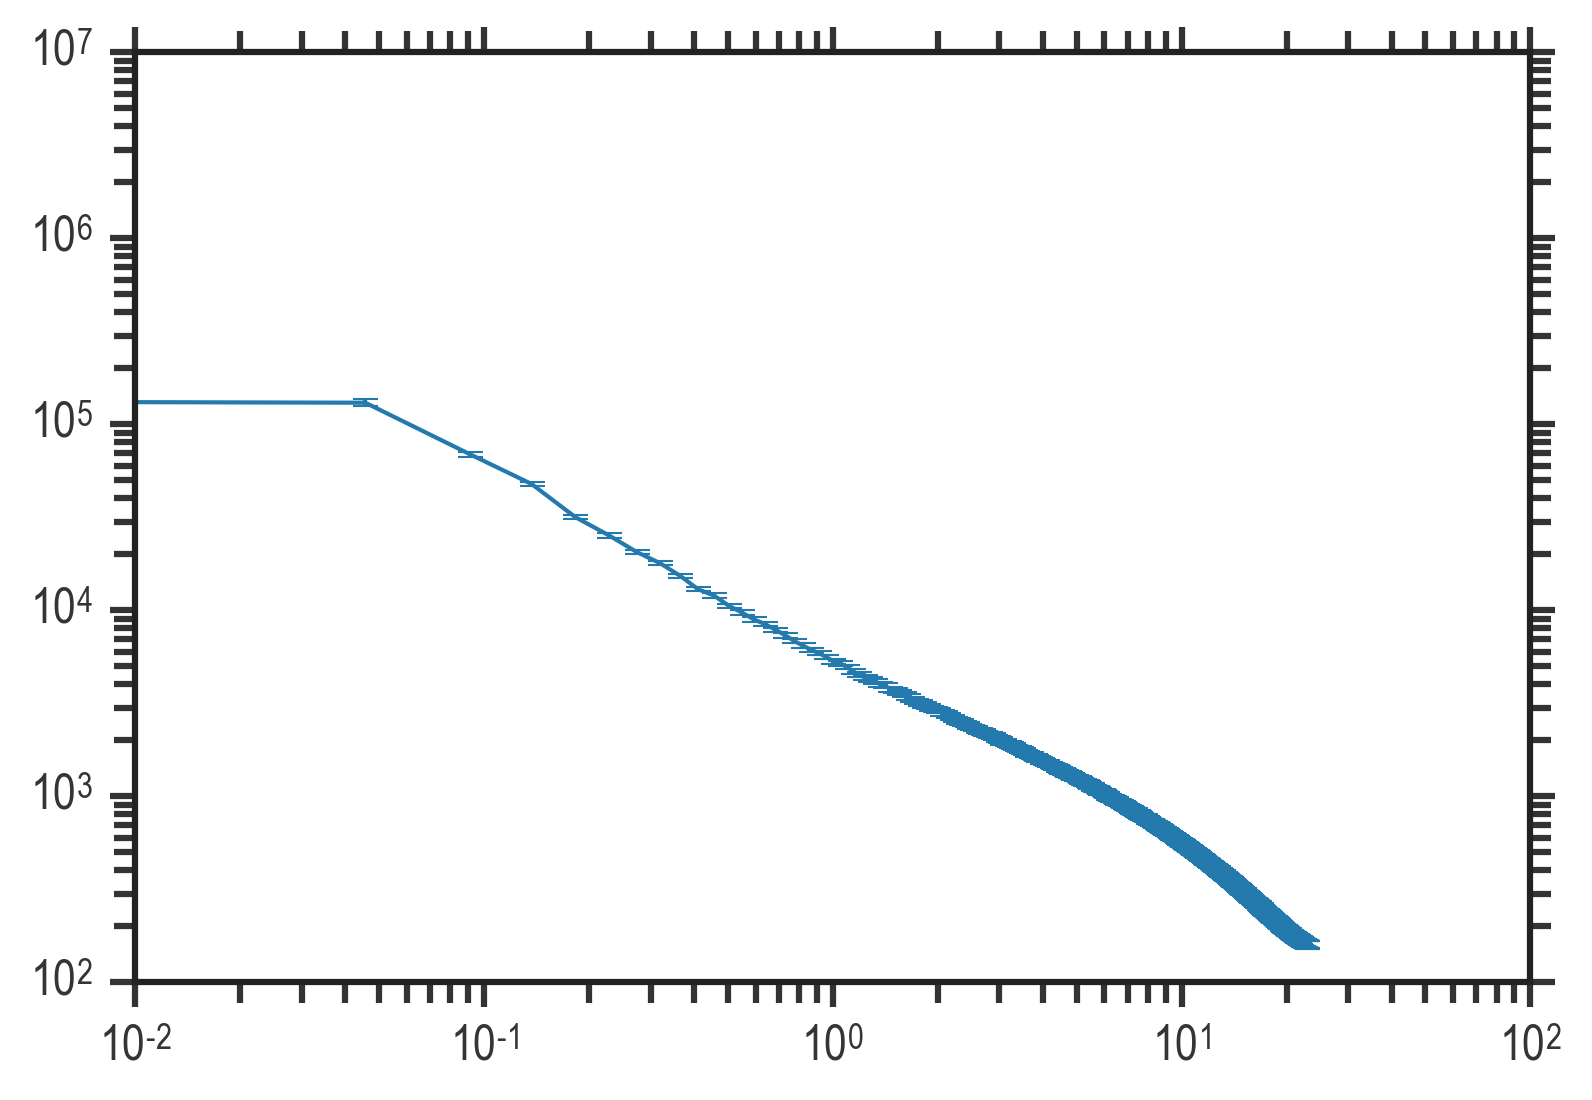

In [81]:
plt.errorbar(freqs_abs, np.mean(all_ffts_1d, axis=0), yerr=errors, linewidth=1)
plt.xscale('log')
plt.yscale('log')

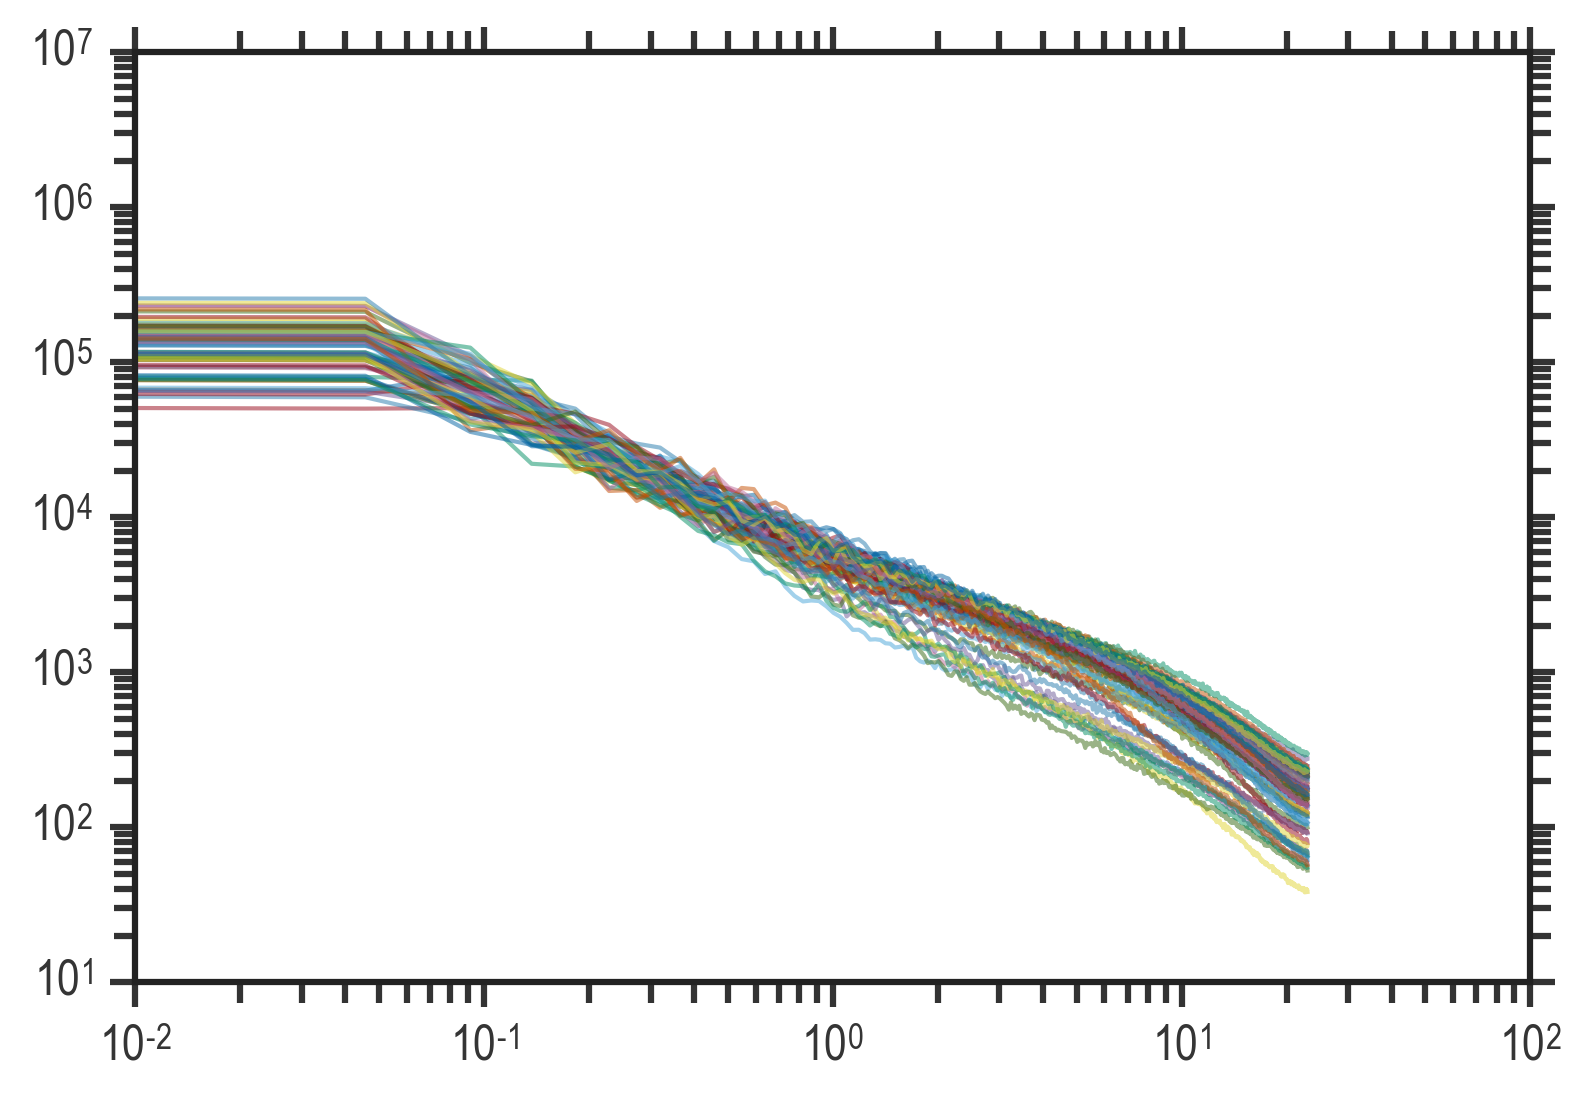

In [86]:
for s in all_ffts_1d:
    plt.plot(freqs_abs, s, alpha=0.5, linewidth=1)
plt.xscale('log')
plt.yscale('log')

## What if we average before taking the modulus?

In [87]:
all_ffts_2d_raw = [np.fft.fftshift((np.fft.fft2(p))) for p in patches]
all_ffts_1d_raw = [rotavg(fft_2d) for fft_2d in all_ffts_2d_raw]

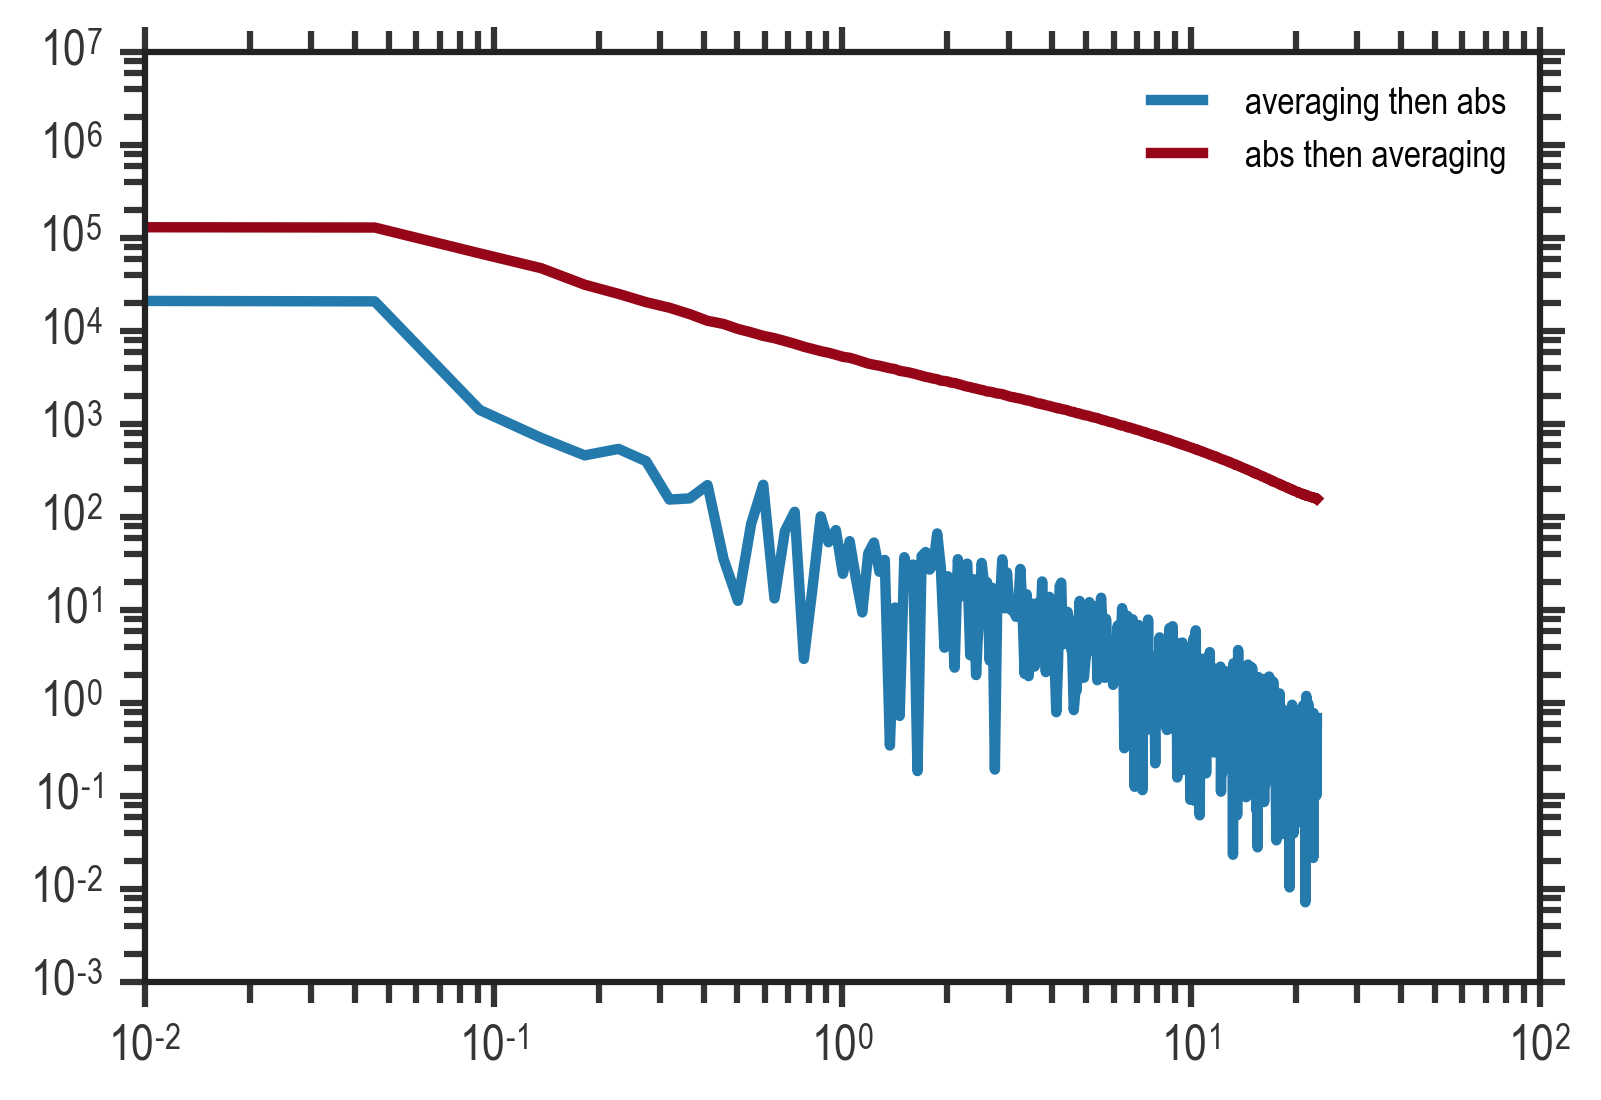

In [92]:
mean_ffts_1d_raw = np.mean(all_ffts_1d_raw, axis=0)
plt.plot(freqs_abs, abs(mean_ffts_1d_raw), label='averaging then abs')
plt.plot(freqs_abs, np.mean(all_ffts_1d, axis=0), label='abs then averaging')
plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False, fontsize=9)

In [93]:
popt_averaged, pcov = curve_fit(func, freqs_abs[1:], abs(mean_ffts_1d_raw)[1:])

In [94]:
popt_averaged

array([ 0.26655385,  3.65194719])